# Import Modules

In [3]:
# General modules & loading data
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from IPython.display import display
import os.path as pth

from tqdm import trange

import pingouin as pg

In [4]:
pd.options.display.max_rows = 20

In [5]:
def normality_test(dataset, timepoint='t1'):
    normality_test_df = pd.DataFrame()

    for i in trange(1,dataset[timepoint].shape[1]-2):
        ntest = pg.normality(dataset[timepoint], dv=dataset[timepoint].iloc[:,i:i+1].columns[0], group='Class')
        normality_test_df = normality_test_df.append({
                        'Variable':dataset[timepoint].iloc[:,i:i+1].columns[0],
                        'Remission_Normality': str(ntest['normal']['Remission']),
                        'Remission_p_value': ntest['pval']['Remission'],
                        'Progression_Normality': str(ntest['normal']['Progression']),
                        'Progression_p_value': ntest['pval']['Progression']
                        }, 
                    ignore_index=True)

    normality_test_df = normality_test_df.reindex(columns = ['Variable',
                                                            'Remission_Normality',
                                                            'Progression_Normality',
                                                            'Remission_p_value',
                                                            'Progression_p_value'])
    return normality_test_df


In [6]:
def significance_test(dataset, timepoint='t1', alpha= 0.05):
    ttest_df = pd.DataFrame()

    for i in trange(1,dataset[timepoint].shape[1]-2):
        res = pg.pairwise_ttests(data=dataset[timepoint], 
                                dv=dataset[timepoint].iloc[:,i:i+1].columns[0], 
                                between='Class', 
                                parametric=False, 
                                correction='auto',
                                alpha=alpha)
        
        res['Feature'] = dataset[timepoint].iloc[:,i:i+1].columns[0]
        res['Significance'] = str((res['p-unc']<alpha)[0])
        ttest_df=ttest_df.append(res)
        
    ttest_df = ttest_df.reindex(columns=['Feature',
                                    'Significance',
                                    'p-unc',
                                    'hedges',
                                    'Contrast', 
                                    'A', 
                                    'B', 
                                    'Paired', 
                                    'Parametric', 
                                    'U-val', 
                                    'Tail'])

    
    ttest_df.sort_values(by='p-unc', inplace=True)
    ttest_df.sort_values(by='hedges', inplace=True)
    ttest_df.reset_index(drop=True, inplace=True)

    return ttest_df

# Load Data

## Load feature set

In [7]:
cwd = os.getcwd()

project_root =  pth.dirname(pth.dirname(cwd))
feat_output_path = pth.join(project_root,'0.1 Feature Extraction\\0.2 Outputs\\0.1 Extracted Features')
output_path = pth.join(pth.dirname(cwd),'0.2 Outputs')

image_feats = {'t1': pd.read_csv(feat_output_path + '\T1\Merged_Features_T1.csv'),
               't2': pd.read_csv(feat_output_path + '\T2\Merged_Features_T2.csv')}


## Test for normality in remission and progression distributions

In [8]:
# normality_test(image_feats, timepoint ='t1')

In [9]:
# normality_test(image_feats, timepoint ='t2')

# Test for Significant Features

In [28]:
n1 = 9
n2 = 64


t1_feature_test = significance_test(image_feats,timepoint='t1',alpha=0.05)
t1_feature_test['Z-score'] = np.NaN
for i in range(len(t1_feature_test)):
    t1_feature_test.loc[i,'Z-score'] = np.abs(t1_feature_test.loc[i,'U-val']-0.5*n1*n2)/np.sqrt((n1*n2*(n1+n2+1))/12)

100%|██████████| 1702/1702 [00:17<00:00, 96.49it/s]


In [29]:
t2_feature_test = significance_test(image_feats,timepoint='t2',alpha=0.05)
t2_feature_test['Z-score'] = np.NaN
for i in range(len(t2_feature_test)):
    t2_feature_test.loc[i,'Z-score'] = np.abs(t2_feature_test.loc[i,'U-val']-0.5*n1*n2)/np.sqrt((n1*n2*(n1+n2+1))/12)

100%|██████████| 1702/1702 [00:17<00:00, 97.00it/s]


In [12]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(t1_feature_test.loc[t1_feature_test['Significance']=='True'])

,Feature,Significance,p-unc,hedges,Contrast,...,Paired,Parametric,U-val,Tail,Z-score
0,CT_original_shape_SurfaceVolumeRatio,True,0.002744,-1.007454,Class,...,False,False,109.0,two-sided,3.003423
3,PET_original_shape_SurfaceVolumeRatio,True,0.003233,-0.979647,Class,...,False,False,112.0,two-sided,2.953087
5,CT_wavelet-HLL_ngtdm_Contrast,True,0.002457,-0.909553,Class,...,False,False,107.0,two-sided,3.036981
16,CT_wavelet-HHH_gldm_SmallDependenceLowGrayLeve...,True,0.003233,-0.830975,Class,...,False,False,112.0,two-sided,2.953087
17,PET_wavelet-LLH_ngtdm_Coarseness,True,0.004455,-0.819385,Class,...,False,False,118.0,two-sided,2.852413
...,...,...,...,...,...,...,...,...,...,...,...
1679,CT_original_glszm_LargeAreaHighGrayLevelEmphasis,True,0.001562,1.720679,Class,...,False,False,477.0,two-sided,3.171212
1682,CT_wavelet-LLL_glszm_LargeAreaHighGrayLevelEmp...,True,0.001313,1.745490,Class,...,False,False,480.0,two-sided,3.221549
1688,CT_wavelet-LLL_glrlm_GrayLevelNonUniformity,True,0.003601,1.851233,Class,...,False,False,462.0,two-sided,2.919529
1691,CT_original_glrlm_GrayLevelNonUniformity,True,0.003412,1.892895,Class,...,False,False,463.0,two-sided,2.936308


In [13]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(t2_feature_test.loc[t2_feature_test['Significance']=='True'])

,Feature,Significance,p-unc,hedges,Contrast,...,Paired,Parametric,U-val,Tail,Z-score
6,CT_original_glrlm_LongRunHighGrayLevelEmphasis,True,0.003799,-1.149451,Class,...,False,False,115.0,two-sided,2.902750
9,CT_wavelet-LLL_glrlm_LongRunHighGrayLevelEmphasis,True,0.006733,-1.077190,Class,...,False,False,126.0,two-sided,2.718182
12,PET_wavelet-HLH_firstorder_Uniformity,True,0.009533,-1.035947,Class,...,False,False,133.0,two-sided,2.600730
13,CT_wavelet-LLL_gldm_LargeDependenceHighGrayLev...,True,0.002597,-1.032873,Class,...,False,False,108.0,two-sided,3.020202
14,PET_wavelet-LHH_glszm_SizeZoneNonUniformityNor...,True,0.002939,-1.020040,Class,...,False,False,111.0,two-sided,2.969866
15,CT_original_gldm_LargeDependenceHighGrayLevelE...,True,0.007445,-1.006742,Class,...,False,False,128.0,two-sided,2.684624
22,PET_wavelet-HLH_glcm_Imc1,True,0.002198,-0.924942,Class,...,False,False,105.0,two-sided,3.070539
28,CT_wavelet-HHH_glszm_SmallAreaLowGrayLevelEmph...,True,0.003412,-0.880981,Class,...,False,False,113.0,two-sided,2.936308
29,PET_wavelet-HLH_glcm_MaximumProbability,True,0.008642,-0.868361,Class,...,False,False,131.0,two-sided,2.634288
95,CT_original_firstorder_Kurtosis,True,0.004226,-0.626677,Class,...,False,False,117.0,two-sided,2.869192


In [32]:
t1_sig_columns = t1_feature_test.loc[t1_feature_test['Significance']=='True']['Feature'].to_list()

In [33]:
t2_sig_columns = t2_feature_test.loc[t2_feature_test['Significance']=='True']['Feature'].to_list()

In [26]:
len(t1_feature_test)

1702

In [34]:
len(t1_sig_columns)

391

In [27]:
len(t2_feature_test)

1702

In [35]:
len(t2_sig_columns)

148

In [18]:
t1_feats = image_feats['t1'].copy()
patients = t1_feats.pop("PID")
classes = t1_feats.pop("Class")
t1_feats.drop(['Delta_Time'],axis=1,inplace=True)
lut = dict(zip(classes.unique(), "grb"))
row_colors = classes.map(lut)

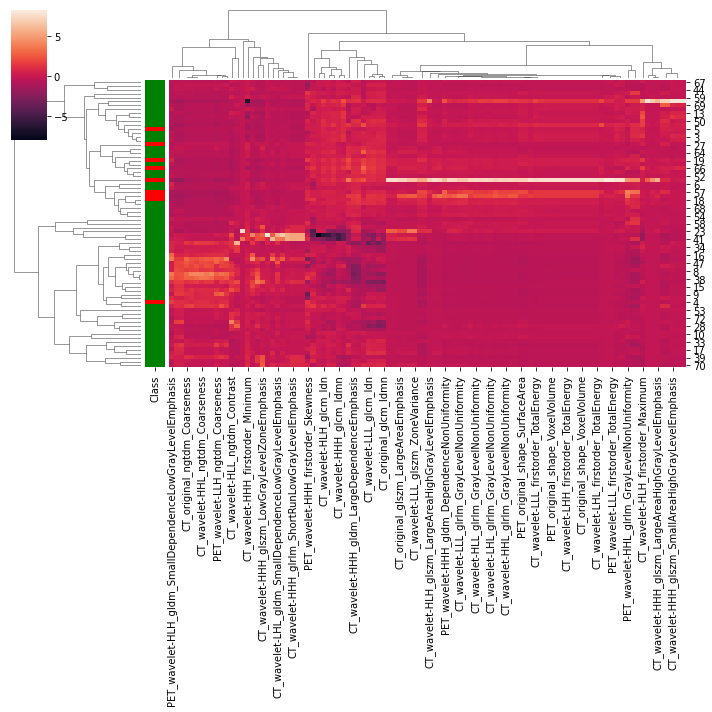

In [19]:
sns.clustermap(image_feats['t1'][t1_sig_columns],z_score=1,row_colors=row_colors,method='average',metric='correlation')

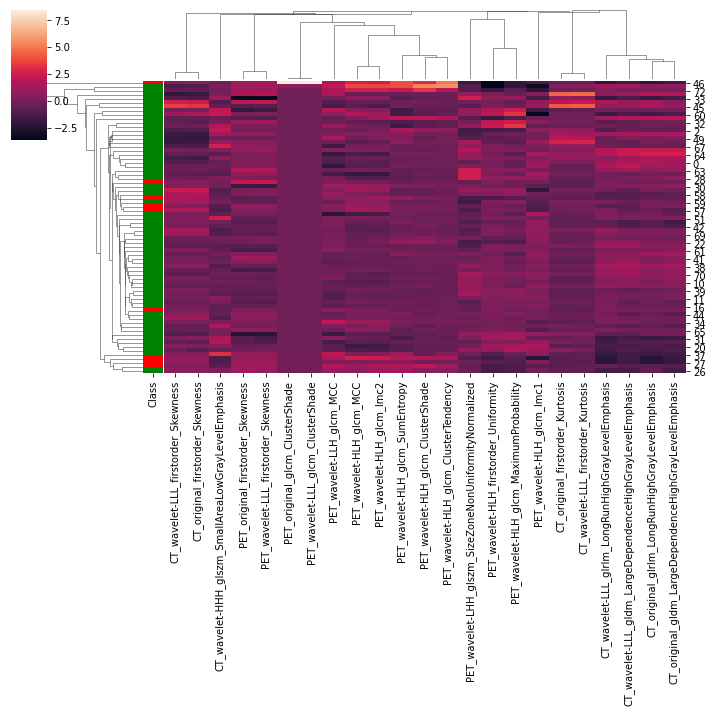

In [25]:
sns.clustermap(image_feats['t2'][t2_sig_columns],z_score=1,row_colors=row_colors,method='centroid',metric='euclidean')

In [21]:
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
methods = ['single','complete','average','weighted']

In [22]:
for i in range(1):
    sns.clustermap(image_feats['t1'][sig_columns],row_colors=row_colors,method='weighted',metric="correlation",standard_scale=1)

NameError: name 'sig_columns' is not defined

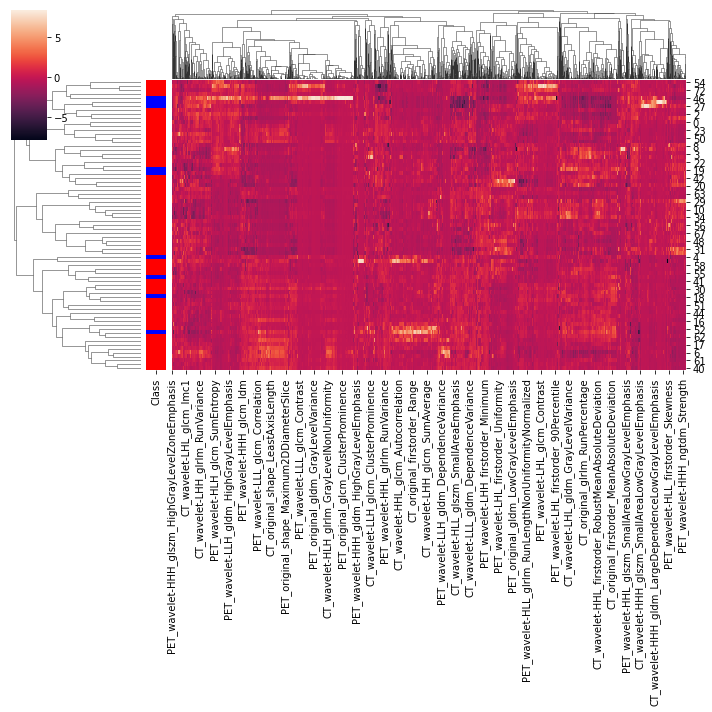

In [ ]:
t2_feats = image_feats['t2'].copy()
patients = t2_feats.pop("PID")
classes = t2_feats.pop("Class")
t2_feats.drop(['Delta_Time'],axis=1,inplace=True)
lut = dict(zip(classes.unique(), "rbg"))
row_colors = classes.map(lut)

sns.clustermap(t2_feats,z_score=1,row_colors=row_colors,method='weighted',metric="correlation")